<a href="https://colab.research.google.com/github/paishowstopper/TSAI/blob/main/EVA5/Session_12/Session_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau

Uploaded files to colab before execution (Uploaded in "framework" folder in github)

In [3]:
from model import BasicBlock, ResNet  
from datatransform import DataTransformation
from dataloader import Loader
from train import Train
from test import Test
import helper
# Reference: https://github.com/davidtvs/pytorch-lr-finder
from lr_finder import LRFinder


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
transform = DataTransformation()
#Different transforms for training and testing in this assignment
trainTransform = transform.AlbumentationTrainTransform()
testTransform = transform.AlbumentationTestTransform()

loader = Loader(trainTransform, testTransform, 512, 4)
#Going with the default variable values set in the data loader
trainloader, testloader, classes = loader.TinyImageNetLoad()


['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', 'n02165456

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


n01770393 n03837869 n07873807 n04067472


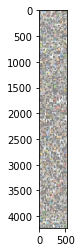

In [6]:
# Show random training images (default 4)
helper.DisplayImages(trainloader, classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


n04540053 n02808440 n02480495 n03902125


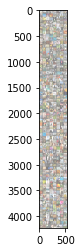

In [7]:
# Show random testing images (default 4)
helper.DisplayImages(testloader, classes)

In [8]:
model = ResNet(BasicBlock, [2, 2, 2, 2], 200).to(device)
model = torch.nn.DataParallel(model)
cudnn.benchmark = True

In [9]:
#Display model summary
helper.DisplayModelSummary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.78E-02


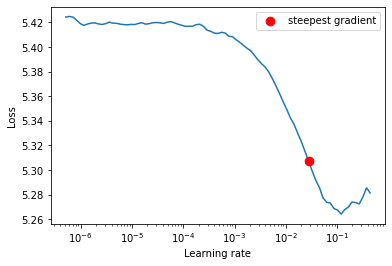

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [11]:
min_loss = min(lr_finder.history['loss'])
min_index = lr_finder.history['loss'].index(min_loss)
lr_value = lr_finder.history['lr'][min_index]
lr_value

0.12045035402587828

In [12]:
optimizer = optim.SGD(model.parameters(), lr=2.78E-02, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2)

In [13]:
epochs = 50

In [14]:
#Training
Train(trainloader, model, criterion, optimizer, scheduler, device, epochs).train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   151] loss: 696.938
Accuracy:  6.322077922077922
[2,   151] loss: 581.160
Accuracy:  15.181818181818182
[3,   151] loss: 520.856
Accuracy:  21.405194805194807
[4,   151] loss: 478.140
Accuracy:  26.444155844155844
[5,   151] loss: 446.284
Accuracy:  30.475324675324675
[6,   151] loss: 417.792
Accuracy:  34.202597402597405
[7,   151] loss: 394.981
Accuracy:  37.19350649350649
[8,   151] loss: 374.677
Accuracy:  39.78051948051948
[9,   151] loss: 356.862
Accuracy:  42.17922077922078
[10,   151] loss: 339.218
Accuracy:  44.64675324675325
[11,   151] loss: 324.370
Accuracy:  46.72077922077922
[12,   151] loss: 309.123
Accuracy:  48.81818181818182
[13,   151] loss: 296.503
Accuracy:  50.71688311688312
[14,   151] loss: 284.312
Accuracy:  52.25714285714286
[15,   151] loss: 271.440
Accuracy:  54.17142857142857
[16,   151] loss: 260.260
Accuracy:  55.824675324675326
[17,   151] loss: 248.163
Accuracy:  57.603896103896105
[18,   151] loss: 236.257
Accuracy:  59.383116883116884
[19,   151]

([696.9379043579102,
  581.1597216129303,
  520.856039762497,
  478.14044666290283,
  446.2835683822632,
  417.79225420951843,
  394.98145270347595,
  374.6768181324005,
  356.8616189956665,
  339.21768748760223,
  324.3697438240051,
  309.12349808216095,
  296.50294756889343,
  284.31160032749176,
  271.4398236274719,
  260.25963521003723,
  248.16251683235168,
  236.2570662498474,
  224.18048322200775,
  214.57015454769135,
  203.05690467357635,
  191.83505284786224,
  182.10168981552124,
  171.29522490501404,
  161.50971776247025,
  150.35386389493942,
  140.96789127588272,
  131.64262521266937,
  122.24529838562012,
  114.54374980926514,
  103.3245467543602,
  96.98806148767471,
  89.12622958421707,
  83.62591695785522,
  76.58963111042976,
  69.3179814517498,
  64.67715156078339,
  59.39457359910011,
  55.14022508263588,
  51.19363187253475,
  47.15313209593296,
  44.768605813384056,
  42.364718809723854,
  38.277978628873825,
  36.434727147221565,
  35.20806506276131,
  32.035768

In [15]:
#Testing
Test(testloader, model, criterion, device).test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 10000 test images: 47 %


([tensor(2.7849, device='cuda:0'),
  tensor(2.8559, device='cuda:0'),
  tensor(2.9825, device='cuda:0'),
  tensor(3.1180, device='cuda:0'),
  tensor(2.8940, device='cuda:0'),
  tensor(2.6113, device='cuda:0'),
  tensor(2.9473, device='cuda:0'),
  tensor(3.1587, device='cuda:0'),
  tensor(2.8903, device='cuda:0'),
  tensor(3.0400, device='cuda:0'),
  tensor(3.2491, device='cuda:0'),
  tensor(2.8584, device='cuda:0'),
  tensor(2.8857, device='cuda:0'),
  tensor(2.7541, device='cuda:0'),
  tensor(2.7501, device='cuda:0'),
  tensor(2.7466, device='cuda:0'),
  tensor(2.8670, device='cuda:0'),
  tensor(2.9280, device='cuda:0'),
  tensor(3.1176, device='cuda:0'),
  tensor(2.6980, device='cuda:0'),
  tensor(2.7740, device='cuda:0'),
  tensor(3.0857, device='cuda:0'),
  tensor(2.8855, device='cuda:0'),
  tensor(2.8961, device='cuda:0'),
  tensor(2.7992, device='cuda:0'),
  tensor(2.8822, device='cuda:0'),
  tensor(3.0366, device='cuda:0'),
  tensor(3.0439, device='cuda:0'),
  tensor(2.8792, dev

In [19]:
classes

['n02124075',
 'n04067472',
 'n04540053',
 'n04099969',
 'n07749582',
 'n01641577',
 'n02802426',
 'n09246464',
 'n07920052',
 'n03970156',
 'n03891332',
 'n02106662',
 'n03201208',
 'n02279972',
 'n02132136',
 'n04146614',
 'n07873807',
 'n02364673',
 'n04507155',
 'n03854065',
 'n03838899',
 'n03733131',
 'n01443537',
 'n07875152',
 'n03544143',
 'n09428293',
 'n03085013',
 'n02437312',
 'n07614500',
 'n03804744',
 'n04265275',
 'n02963159',
 'n02486410',
 'n01944390',
 'n09256479',
 'n02058221',
 'n04275548',
 'n02321529',
 'n02769748',
 'n02099712',
 'n07695742',
 'n02056570',
 'n02281406',
 'n01774750',
 'n02509815',
 'n03983396',
 'n07753592',
 'n04254777',
 'n02233338',
 'n04008634',
 'n02823428',
 'n02236044',
 'n03393912',
 'n07583066',
 'n04074963',
 'n01629819',
 'n09332890',
 'n02481823',
 'n03902125',
 'n03404251',
 'n09193705',
 'n03637318',
 'n04456115',
 'n02666196',
 'n03796401',
 'n02795169',
 'n02123045',
 'n01855672',
 'n01882714',
 'n02917067',
 'n02988304',
 'n043

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is depr

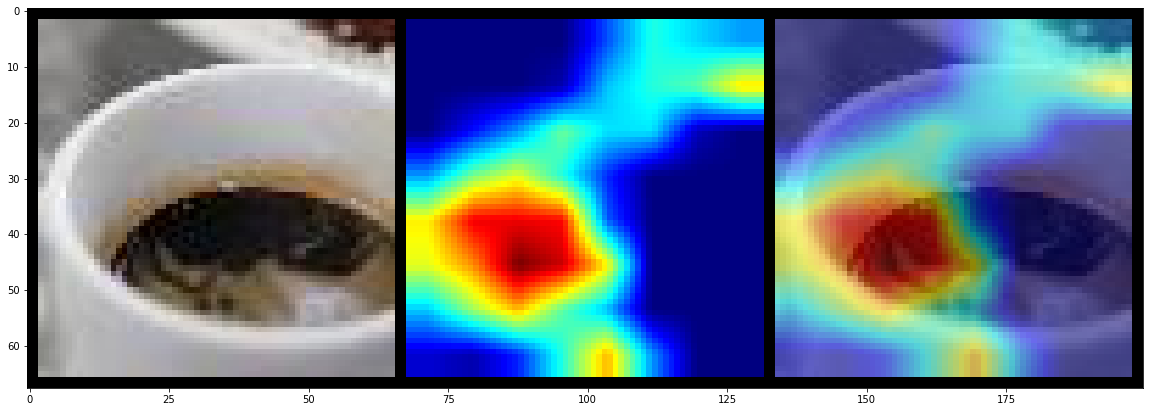

Prediction : n07920052, Actual : n07920052


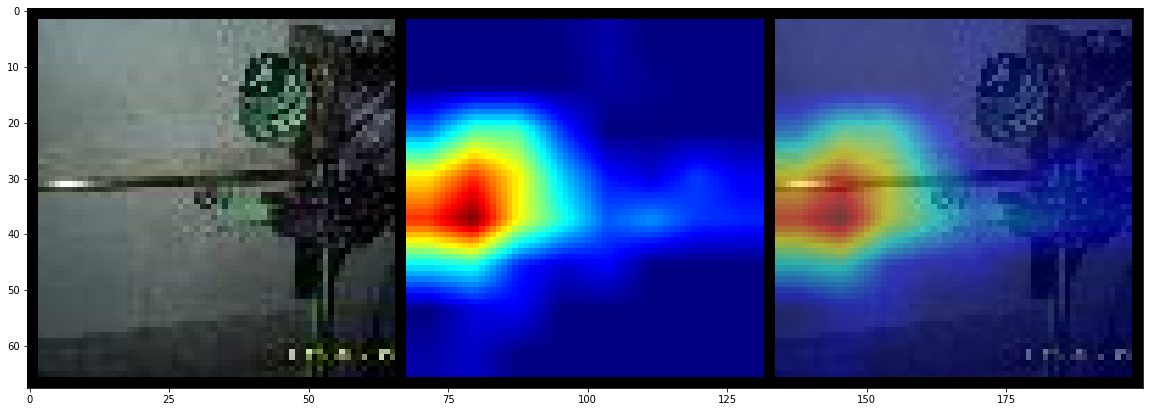

Prediction : n04311004, Actual : n02788148


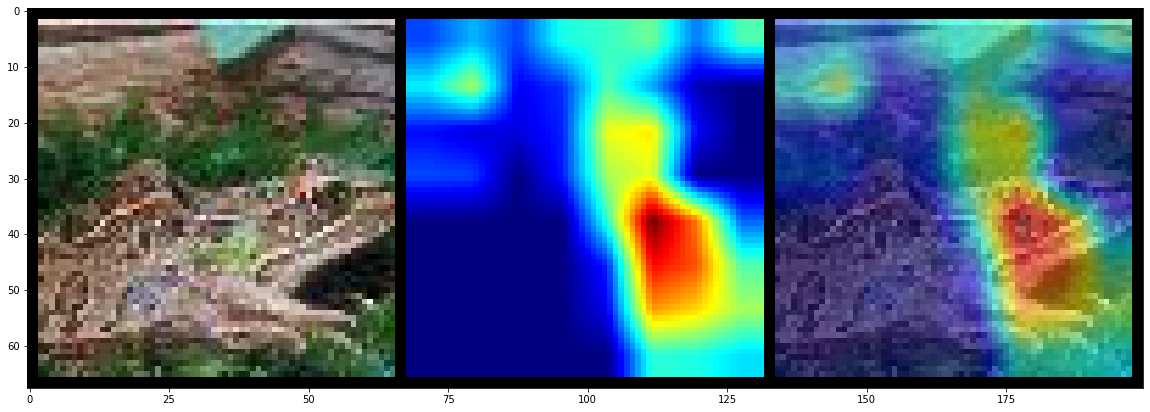

Prediction : n01644900, Actual : n01644900


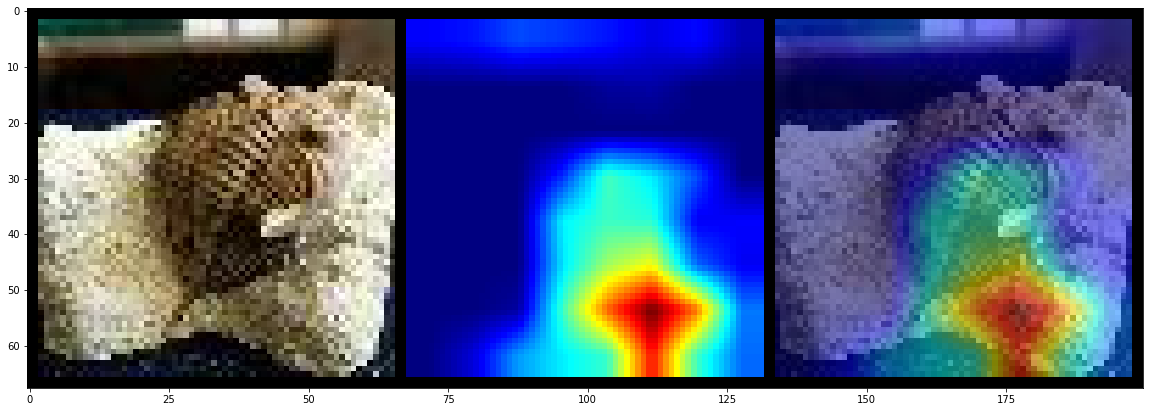

Prediction : n01768244, Actual : n01768244


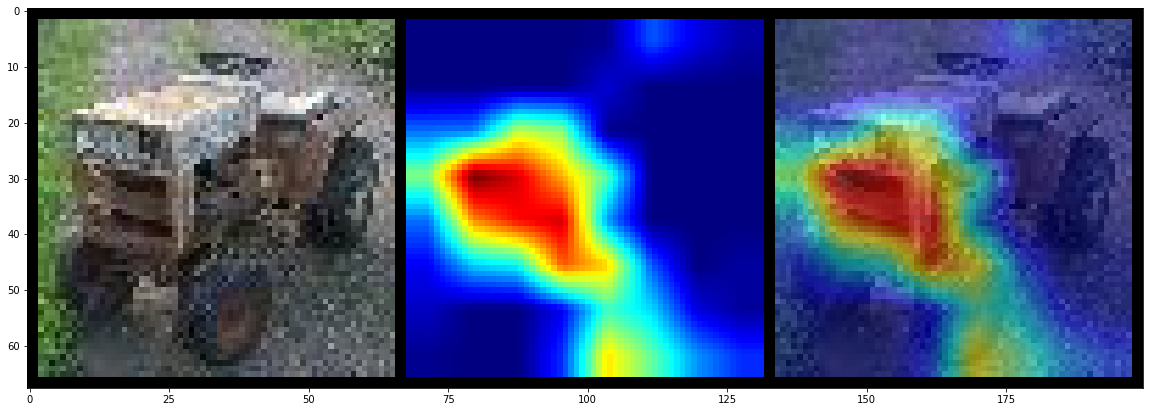

Prediction : n04465501, Actual : n04465501


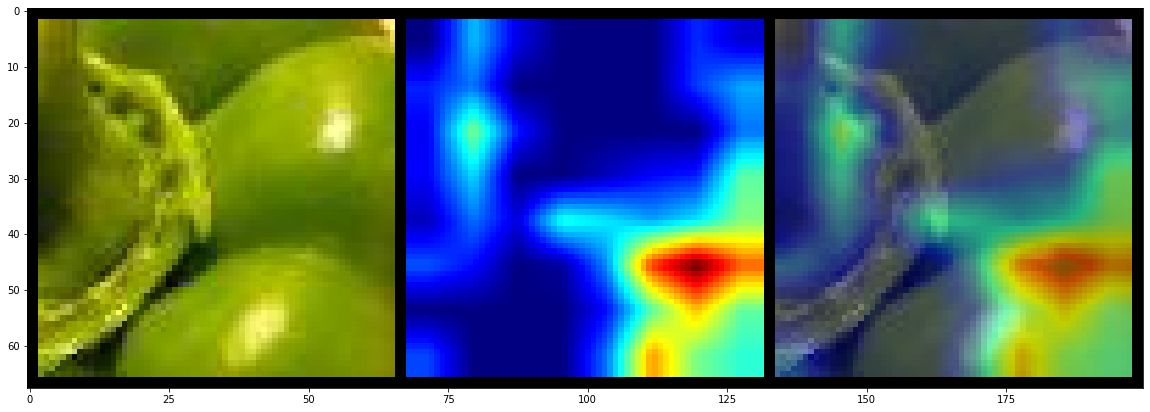

Prediction : n02165456, Actual : n07720875


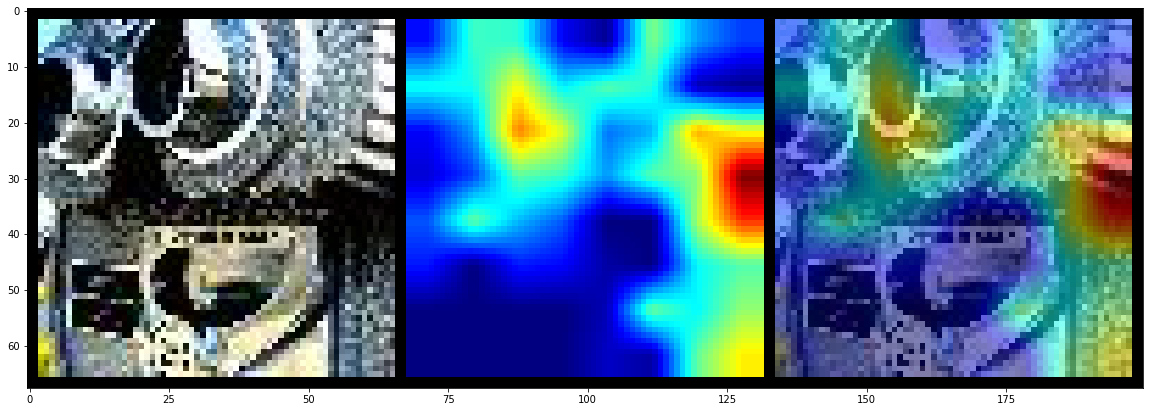

Prediction : n03400231, Actual : n02841315


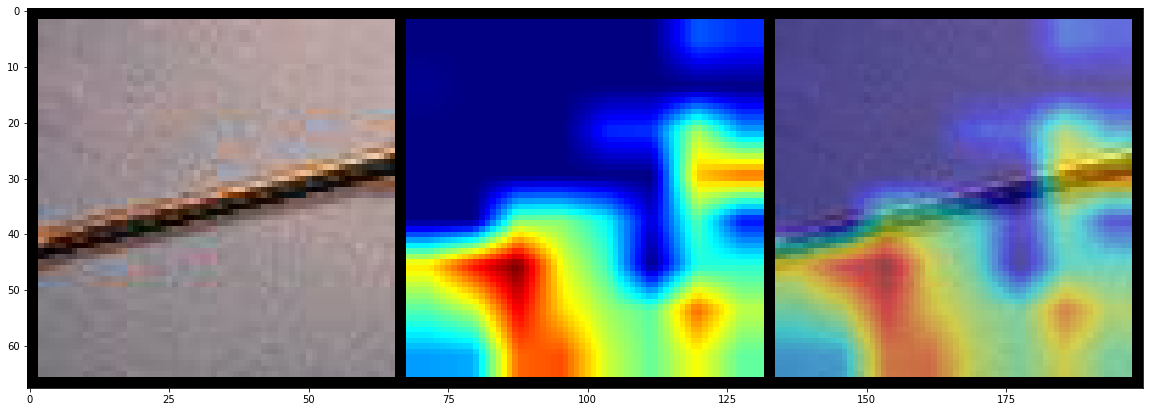

Prediction : n04597913, Actual : n03804744


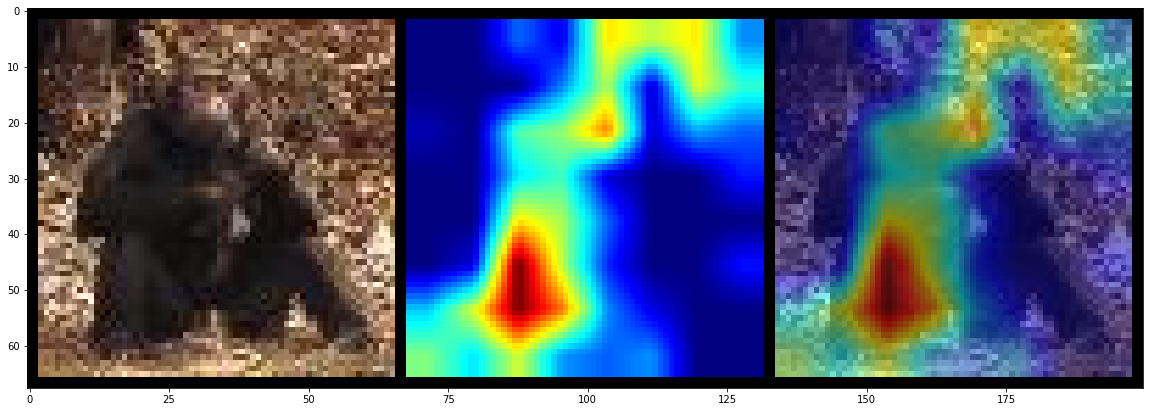

Prediction : n02481823, Actual : n02481823


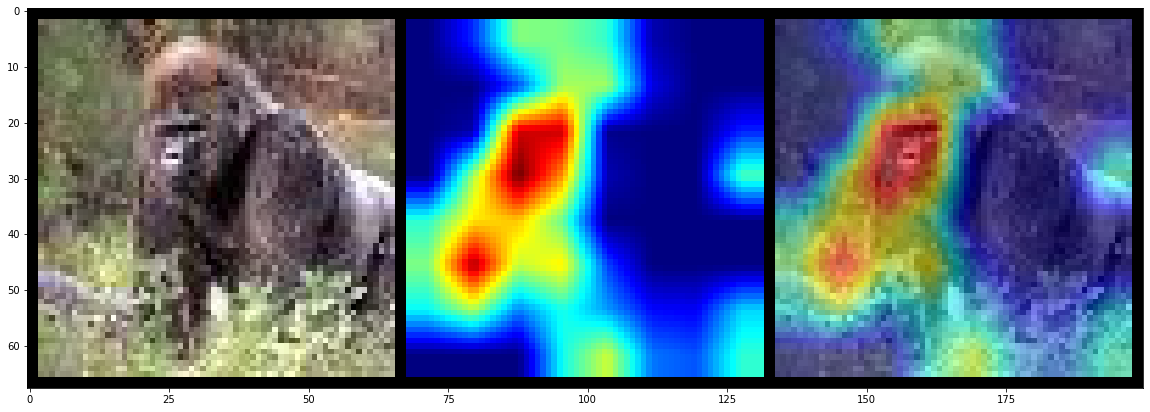

Prediction : n02403003, Actual : n02480495


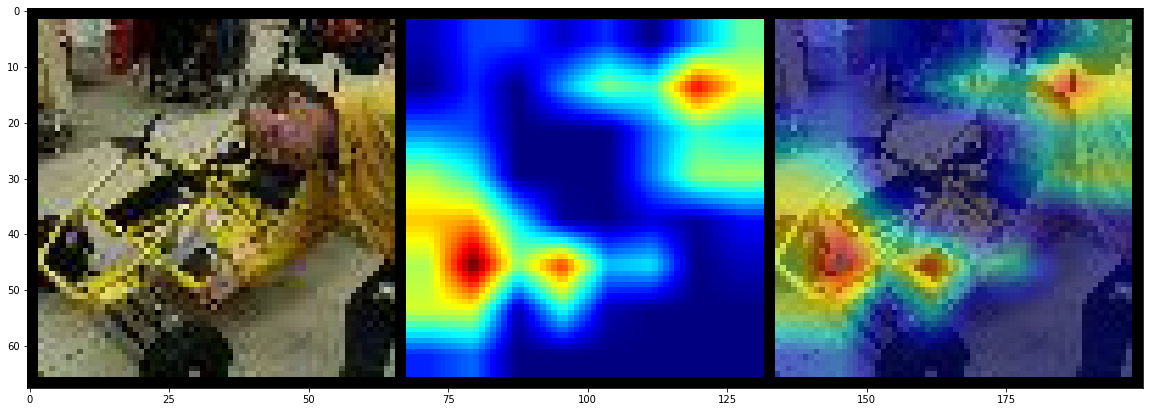

Prediction : n07583066, Actual : n03444034


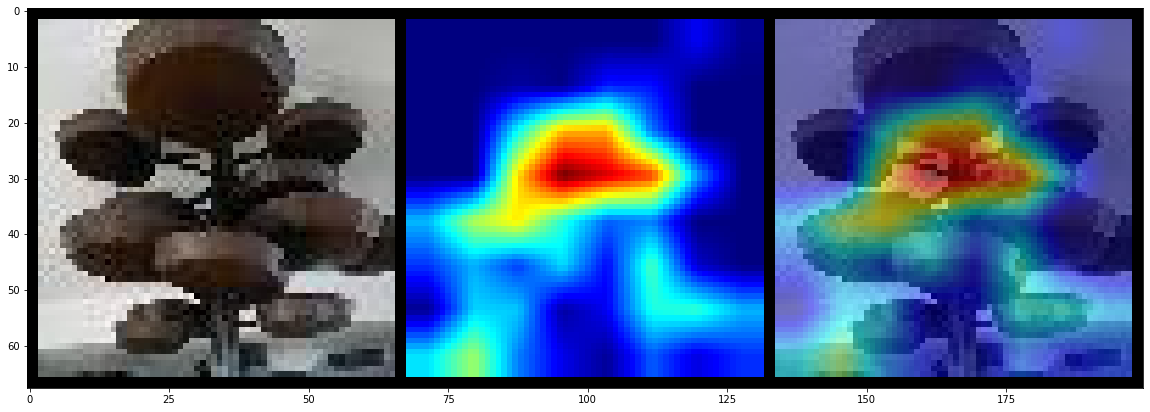

Prediction : n07920052, Actual : n03400231


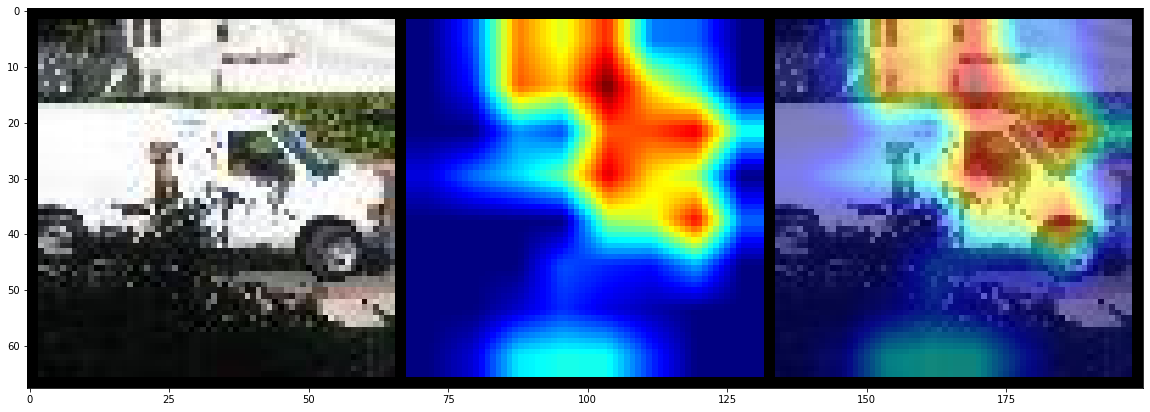

Prediction : n03670208, Actual : n03796401


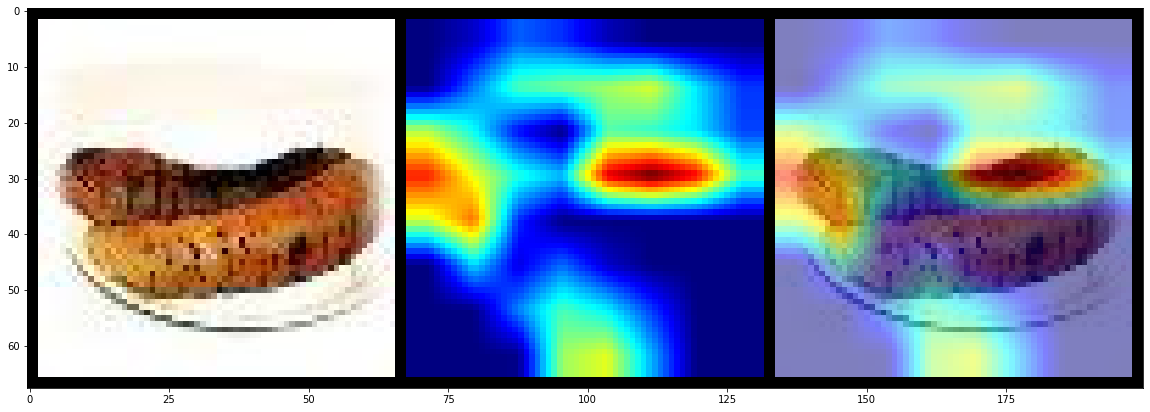

Prediction : n07711569, Actual : n02321529


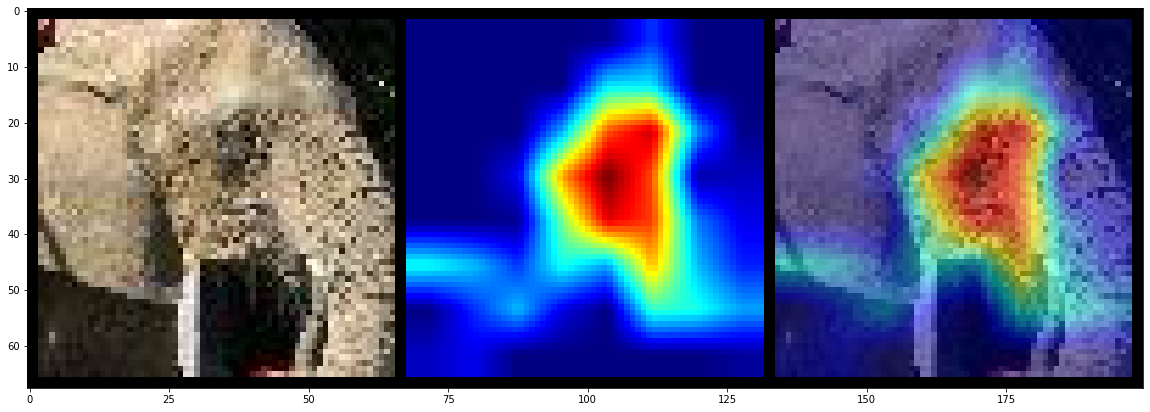

Prediction : n02504458, Actual : n02504458


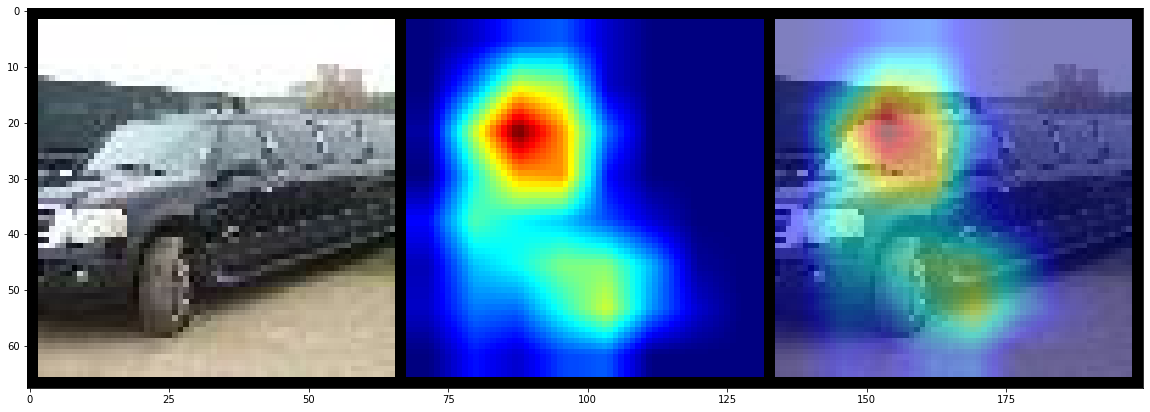

Prediction : n03670208, Actual : n03670208


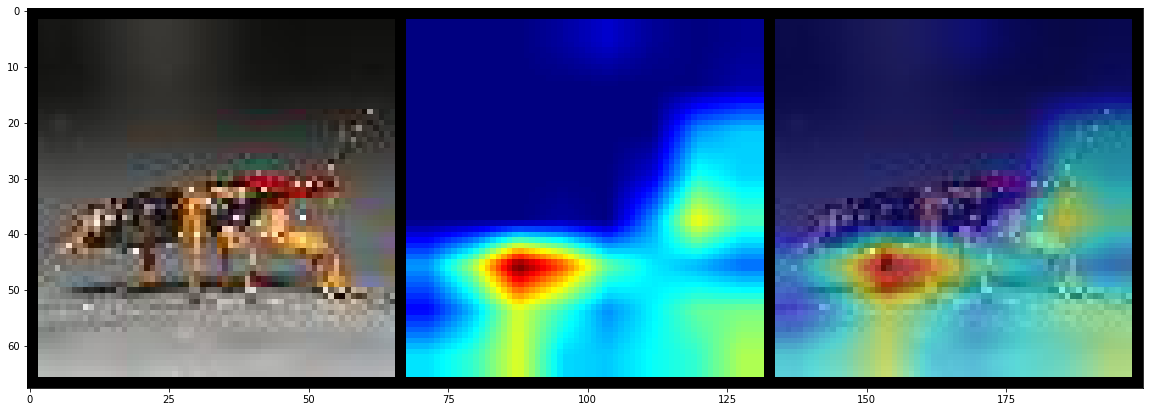

Prediction : n02233338, Actual : n02233338


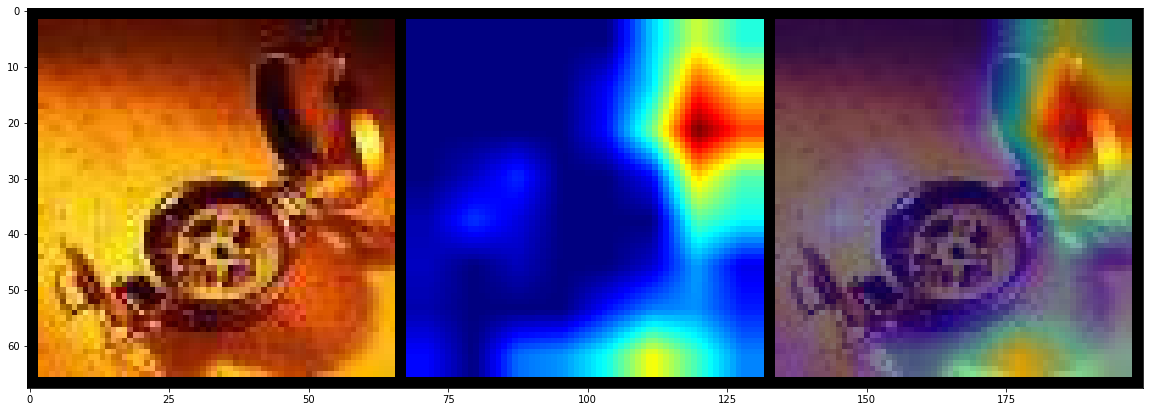

Prediction : n07920052, Actual : n03706229


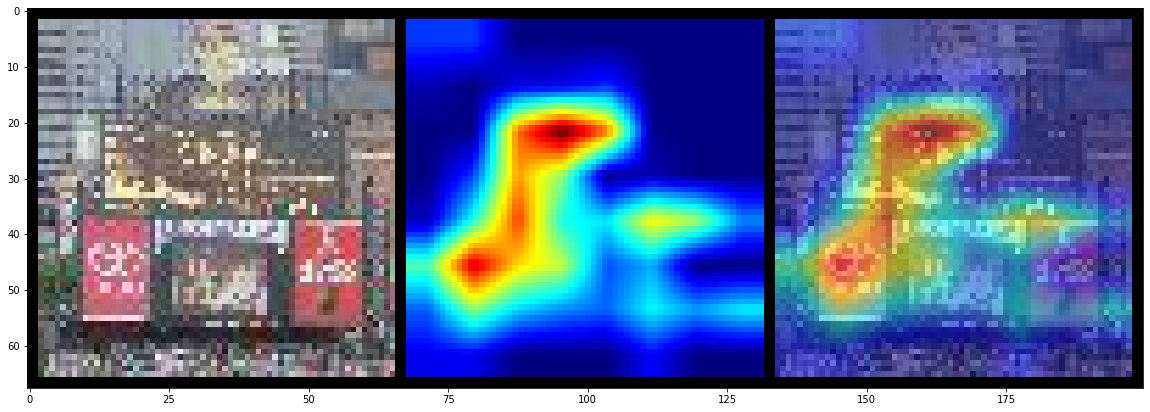

Prediction : n04149813, Actual : n04149813


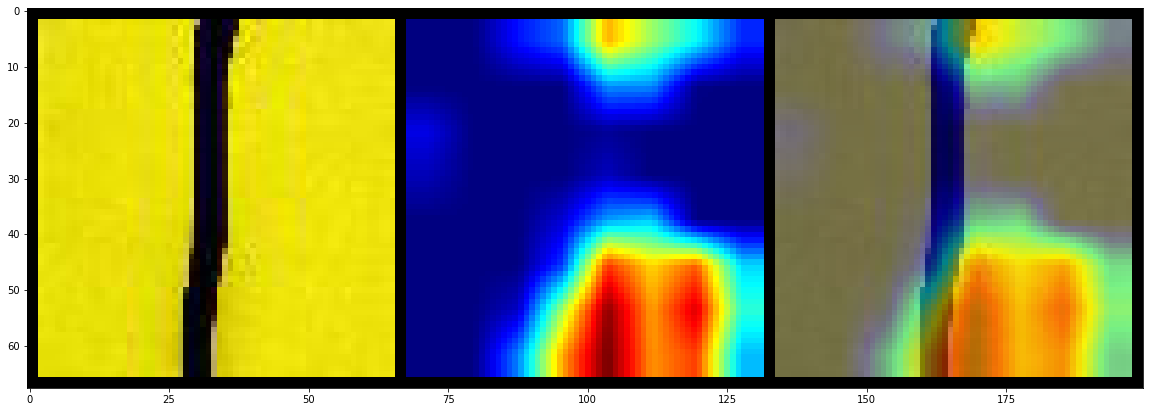

Prediction : n04507155, Actual : n03804744


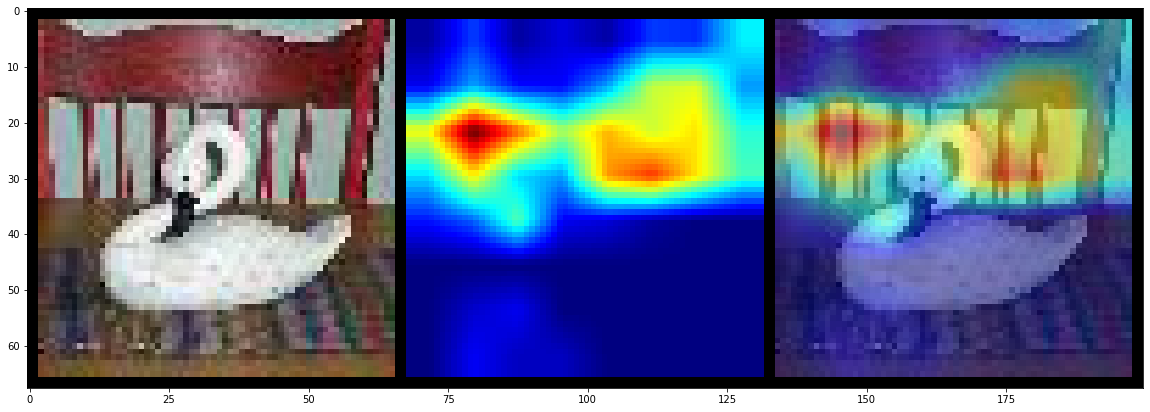

Prediction : n03201208, Actual : n03201208


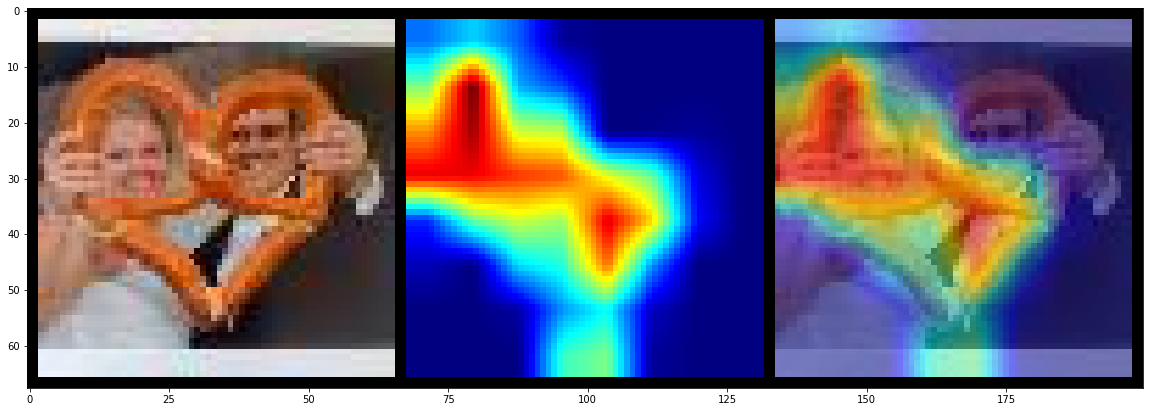

Prediction : n07695742, Actual : n07695742


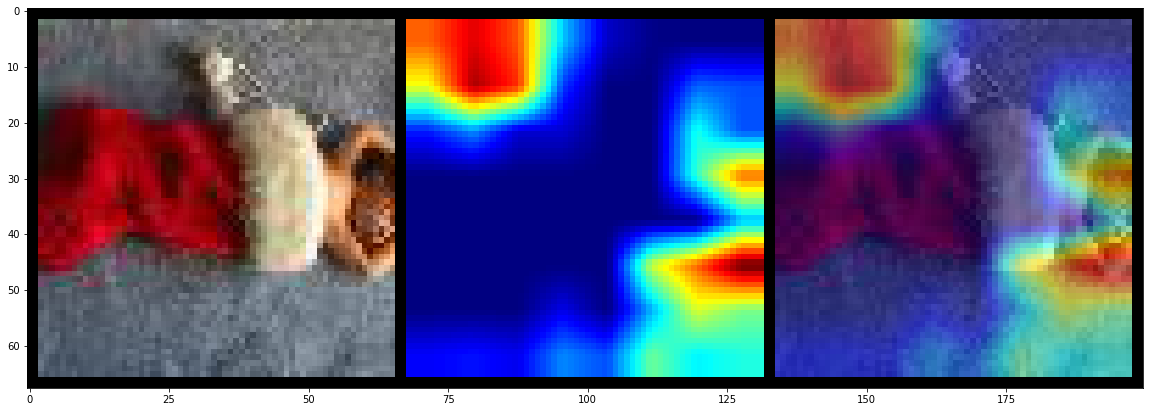

Prediction : n02486410, Actual : n03026506


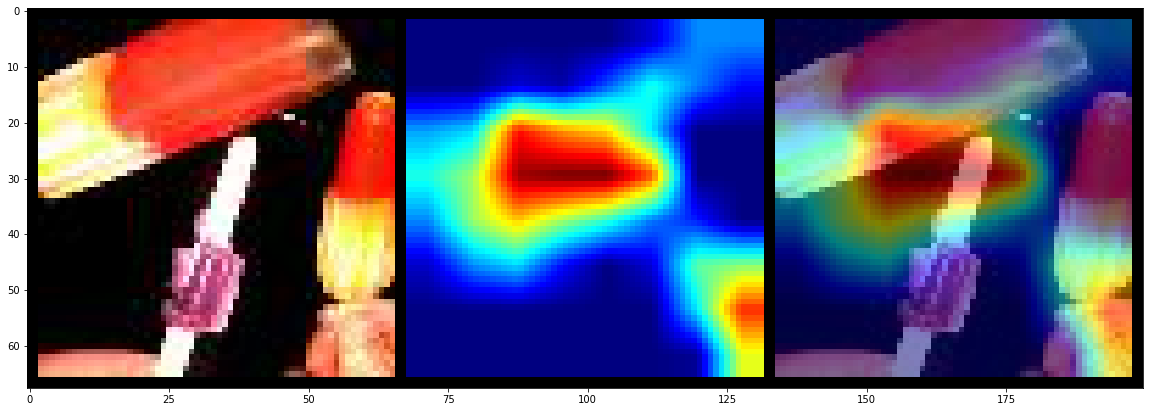

Prediction : n03937543, Actual : n07615774


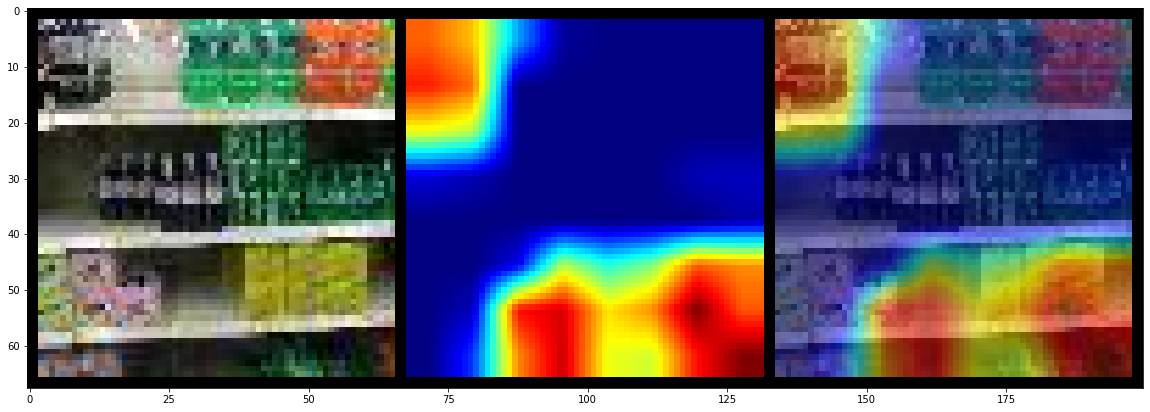

Prediction : n03983396, Actual : n03983396


In [18]:
helper.DisplayGradCamImages(model.module, 'resnet', 'layer4', testloader, classes, device, 25)